# Estimating the parameters of the SEIAHR model
In this notebook we are going to use COVID-19 series from Brasil adjusted by the nowcasting model of Bastos et al.(2020) to estimate key parameters and make projections

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
import theano

## Loading the data

Text(0.5, 1.0, 'Mortes COVID-19')

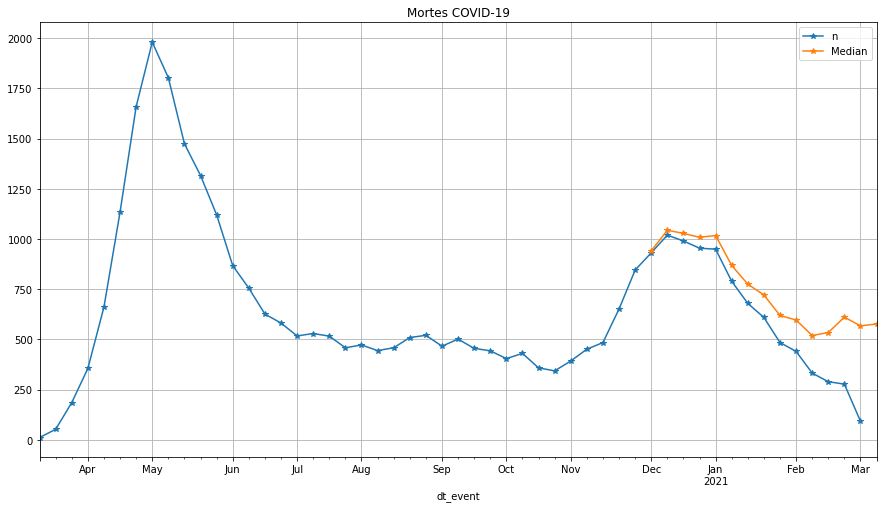

In [17]:
m_covid = pd.read_csv("mortes_covid.csv", parse_dates=True,na_values='NA')
m_covid['dt_event']  = pd.to_datetime(m_covid['dt_event'])
fig, ax = plt.subplots(1,1,figsize=(15,8))
m_covid.set_index('dt_event', inplace=True)
m_covid[m_covid.Estado=='RJ'][['n','Median']].plot(ax=ax,style="-*", grid=True);
plt.title('Mortes COVID-19')

Text(0.5, 1.0, 'Mortes SRAG')

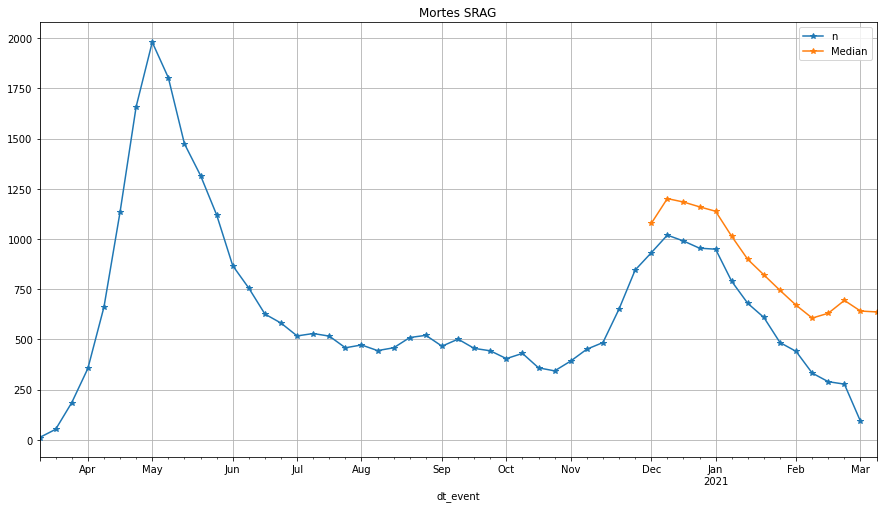

In [16]:
m_srag = pd.read_csv("mortes_srag.csv", parse_dates=True,na_values='NA')
m_srag['dt_event']  = pd.to_datetime(m_srag['dt_event'])
fig, ax = plt.subplots(1,1,figsize=(15,8))
m_srag.set_index('dt_event', inplace=True)
m_srag[m_srag.Estado=='RJ'][['n','Median']].plot(ax=ax,style="-*", grid=True);
plt.title('Mortes SRAG')

Text(0.5, 1.0, 'Hospitalizações COVID-19')

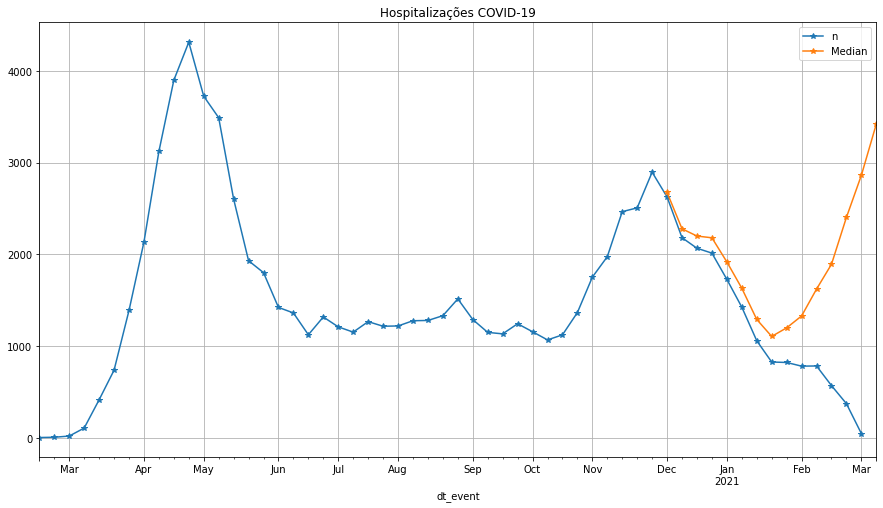

In [15]:
h_covid = pd.read_csv("hosp_covid.csv", parse_dates=True,na_values='NA')
h_covid['dt_event']  = pd.to_datetime(h_covid['dt_event'])
fig, ax = plt.subplots(1,1,figsize=(15,8))
h_covid.set_index('dt_event', inplace=True)
h_covid[h_covid.Estado=='RJ'][['n','Median']].plot(ax=ax,style="-*", grid=True);
plt.title('Hospitalizações COVID-19')

Text(0.5, 1.0, 'Hospitalizações SRAG')

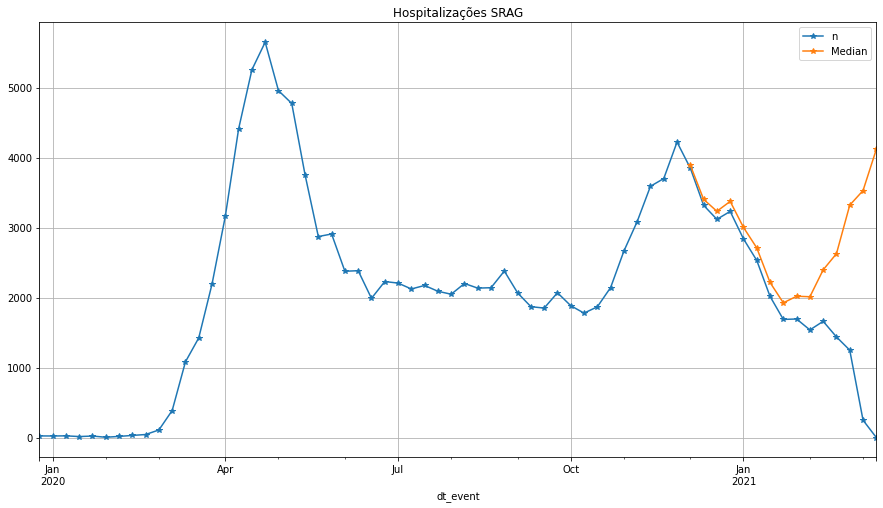

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
h_srag = pd.read_csv("hosp_srag.csv", parse_dates=True,na_values='NA')
h_srag['dt_event']  = pd.to_datetime(h_srag['dt_event'])
h_srag.set_index('dt_event', inplace=True)
h_srag[h_srag.Estado=='RJ'][['n','Median']].plot(ax=ax,style="-*", grid=True);
plt.title('Hospitalizações SRAG')

## The SEIAHR model
The SEIAHR model is used here with two auxiliary compartments to  represent cumulative cases and deaths. The state of the model is scaled as fractions of the total population.

With the force of infection $\lambda=\beta(I+A+(1-\rho)H)$, we have

\begin{align}
\frac{dS}{dt}&=-\lambda [(1-\chi) S] \\
\frac{dE}{dt}&= \lambda [(1-\chi) S] -\alpha E\\
\frac{dI}{dt}&= (1-p)\alpha E - (\phi+\delta)I\\
\frac{dA}{dt}&= p\alpha E -\delta A\\
\frac{dH}{dt}&= \phi I -(\rho+\mu) H\\
\frac{dR}{dt}&= \delta I +\delta H + \gamma A\\
\frac{dC}{dt}&= \phi I\\
\frac{dD}{dt}&= \mu H
\end{align}

For the inference below we will consider $\chi=0$ As we will only fit the second wave of the curve above.

In [12]:
def SEIAHR(y,t, p):
    S, E, I, A, H, R, C, D = y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7]
    𝜒 = 0
    𝜙, 𝛽, 𝜌, 𝛿, 𝛾, 𝛼, 𝜇, p = \
    p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7]
    𝜆 = 𝛽 * (I + A)
    # Turns on Quarantine on day q and off on day q+r
#     chi *= ((1 + np.tanh(t - q)) / 2) * ((1 - np.tanh(t - (q + r))) / 2)
    return [
        -𝜆 * ((1 - 𝜒) * S),  # dS/dt
        𝜆 * ((1 - 𝜒) * S) - 𝛼 * E,  # dE/dt
        (1 - p) * 𝛼 * E - 𝛿 * I - 𝜙 * I,  # dI/dt
        p * 𝛼 * E - 𝛾 * A, #dA/dt
        𝜙 * I - (𝜌 + 𝜇) * H,  # dH/dt
        𝛿 * I + 𝜌 * H + 𝛾 * A,  # dR/dt
        𝜙 * I,  # (1-p)*𝛼*E+ p*𝛼*E # Hospit. acumuladas
        𝜇 * H  # Morte acumuladas
    ]

def Model(y,t,p):
    '''Wrapper returning only Hospitalizations and deaths'''
    y = SEIAHR(y,t,p)
    return y[-2:]

In [13]:
seiarh_model = DifferentialEquation(
    func=Model,
    times=np.arange(0, 20, 0.25),
    n_states=2,
    n_theta=5,
    t0=0,
)

Sabemos que a transmissibilidade varia ao longo do tempo mas não temos dados precisos para calculá-la, logo vamos estimar uma função $\beta(t)$ como um processo gaussiano.
$$\beta(t) \sim {\cal GP}(m(t),k(t,t'))$$
com with a gaussian prior over $\beta$

In [30]:
# Filtering by state and by dates where there were cases reported
h_covid_RJ = h_covid[h_covid.Estado=='RJ'].dropna(subset=['n'])
m_covid_RJ = m_covid[m_covid.Estado=='RJ'].dropna(subset=['n'])
m_covid_RJ.tail()#[['n','Median','LI', 'LS']].tail().to_latex()

,Unnamed: 0,Estado,dt_event_ew,dt_event_ey,n,Median,LI,LS,LIb,LSb,cum
dt_event,,,,,,,,,,,
2021-02-07,566,RJ,6.0,2021.0,440.0,596.0,546.975,665.000,578.00,618.0,46538.5
2021-02-14,567,RJ,7.0,2021.0,332.0,519.0,465.000,600.000,498.00,544.0,47057.5
2021-02-21,568,RJ,8.0,2021.0,289.0,534.0,452.000,639.025,504.00,571.0,47591.5
2021-02-28,569,RJ,9.0,2021.0,277.0,610.5,497.000,789.050,564.75,661.0,48202.0
2021-03-07,570,RJ,10.0,2021.0,92.0,567.0,373.975,875.000,489.00,668.0,48769.0


In [20]:
#cumulative deaths
m_covid['cum'] =m_covid['Median'].cumsum()
#cumulative  cases
h_covid['cum'] =h_covid['Median'].cumsum()
X = np.arange(len(h_covid[h_srag.Estado=='RJ'].dropna()))
yobs = np.hstack(h_covid.cum.values, m_covid.cum.values)
print(yobs)
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2) #curves variances
    # GP
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)
    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    𝛽_ = gp.prior("𝛽_", X=X)
    
    ##
    # reamining parameters
    𝜙 = pm.Uniform('𝜙', lower=.01,upper=2)
    
    
    sir_curves = seiahr_model(y0=[0.99, 0.01], theta=[𝜙,𝛽])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

<ipython-input-20-92edc34d069a>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = np.arange(len(h_covid[h_srag.Estado=='RJ'].dropna()))


ValueError: cannot reindex from a duplicate axis

In [ ]:
h_covid[h_srag.Estado=='RJ'].dropna()